In [142]:
import xarray as xr
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from scipy import ndimage


In [2]:
# Settings
height = 2
polar_boolean = True
swath_boolean = True

In [ ]:
if swath_boolean == True:
    nc_file_paths = ['/Users/acheung/data/TC_RADAR/swath/tc_radar_v3k_1997_2019_xy_rel_swath_ships.nc?download=1',
                     '/Users/acheung/data/TC_RADAR/swath/tc_radar_v3k_2020_2022_xy_rel_swath_ships.nc?download=1']   
else:
    nc_file_paths = ['/Users/acheung/data/TC_RADAR/merged/tc_radar_v3k_1997_2019_xy_rel_merge_ships.nc?download=1',
                 '/Users/acheung/data/TC_RADAR/merged/tc_radar_v3k_2020_2022_xy_rel_merge_ships.nc?download=1']


tc_radar_data_pre = xr.open_mfdataset(nc_file_paths,combine='nested',concat_dim='num_cases')
tc_radar_data_pre['num_cases'] = range(0,len(tc_radar_data_pre['num_cases']))

# Set initial conditions and filtering
year_cases = tc_radar_data_pre['swath_year'].load().where(
    tc_radar_data_pre['swath_year'].load()>=2000).dropna('num_cases')['num_cases']

stype_cases = tc_radar_data_pre['stype_ships'].load().where((
    tc_radar_data_pre['stype_ships'].load()== 1) | (
    tc_radar_data_pre['stype_ships'].load()== 2)).dropna('num_cases')['num_cases']

tilt_mag = tc_radar_data_pre.sel(level=[5,5.5,6,6.5])['tc_tilt_magnitude'].max(
    dim='level').dropna(dim='num_cases')

selected_tilt_level_inds = tc_radar_data_pre.sel(num_cases=tilt_mag['num_cases'],
                      level=[5,5.5,6,6.5])['tc_tilt_magnitude'].argmax(dim='level',keep_attrs=True)

tilt_angs = tc_radar_data_pre.sel(num_cases=tilt_mag['num_cases'],
                      level=[5,5.5,6,6.5])['tc_tilt_direction']*(180/np.pi)

list_of_lists = [year_cases.values,stype_cases.values,tilt_mag['num_cases'].values]

result = list(reduce(lambda a, b: set(a) & set(b), list_of_lists))

filtered_tc_radar = tc_radar_data_pre.sel(num_cases=result)

data_selection = 'recentered_reflectivity'

filtered_data = filtered_tc_radar.sel(level=2)[data_selection]

rotated_images = []
for rot_i in filtered_refs['num_cases']:
# for rot_i in [200]:

    print(int(rot_i))
    img_rotate = ndimage.rotate(filtered_data.sel(num_cases=int(rot_i)), 
                                float(tilt_angs.sel(num_cases=int(rot_i)).isel(
                                    level=int(selected_tilt_level_inds.sel(num_cases=int(rot_i))))),
                                reshape=False,order=0,mode='constant',cval=np.nan)
    rotated_images.append(img_rotate)


0
1
2
3
4
5
6
7
8
9
10
12
13
14
16
17


In [ ]:
filtered_data

In [ ]:
finalx,finaly = np.meshgrid(filtered_data.x_dist.data,filtered_data.y_dist.data)
rotated_images_xr = xr.DataArray(rotated_images,dims=["case","x", "y"],coords=dict(
        x=(["x", "y"], finalx),
        y=(["x", "y"], finaly),
        case=(range(0,len(rotated_images)))
    ))

In [ ]:
finaly.shape

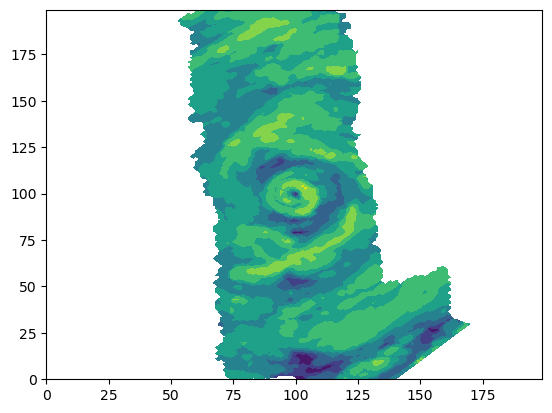

In [399]:
plt.contourf(img_rotate)

In [400]:
img_rotate.shape

(200, 200)

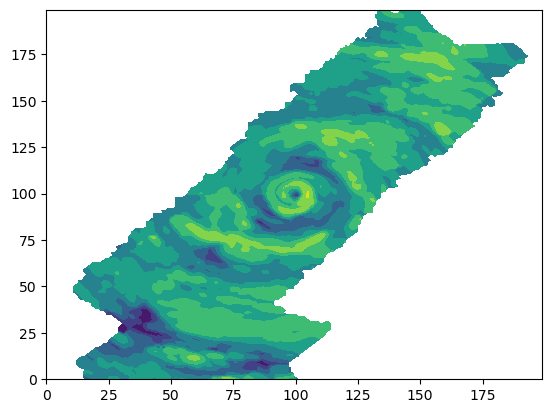

In [401]:
plt.contourf(filtered_refs.sel(num_cases=rot_i))

In [359]:
float(tilt_angs.sel(num_cases=rot_i).isel(
                                    level=int(selected_tilt_level_inds.sel(num_cases=rot_i))))

-45.0

In [224]:
tilt_angs.values

array([171.88733854,   0.        ,   0.        , 171.88733854,
         0.        , 114.59155903,   0.        , 171.88733854,
       171.88733854, 114.59155903,   0.        ,  57.29577951,
         0.        ,   0.        ,   0.        , 171.88733854,
         0.        ,   0.        , 171.88733854,   0.        ,
        57.29577951, 171.88733854,   0.        , 171.88733854,
        57.29577951, 114.59155903,   0.        , 171.88733854,
         0.        ,   0.        ,   0.        ,   0.        ,
       114.59155903,   0.        ,  57.29577951, 114.59155903,
       171.88733854, 114.59155903, 114.59155903,   0.        ,
         0.        ,   0.        , 114.59155903, 114.59155903,
       114.59155903, 171.88733854, 114.59155903, 114.59155903,
         0.        ,  57.29577951,   0.        , 114.59155903,
         0.        , 171.88733854, 171.88733854,  57.29577951,
       114.59155903, 114.59155903,   0.        ,  57.29577951,
        57.29577951, 114.59155903, 171.88733854, 171.88

In [139]:
img_rotate = ndimage.rotate(filtered_refs, tilt_ang, reshape=False)

<xarray.DataArray 'swath_reflectivity' (num_cases: 672, lats: 200, lons: 200)> Size: 108MB
dask.array<getitem, shape=(672, 200, 200), dtype=float32, chunksize=(103, 34, 34), chunktype=numpy.ndarray>
Coordinates:
  * num_cases  (num_cases) int64 5kB 0 1 2 3 4 5 ... 1175 1176 1187 1188 1189
    level      float32 4B 2.0
Dimensions without coordinates: lats, lons
Attributes:
    units:    dBZ

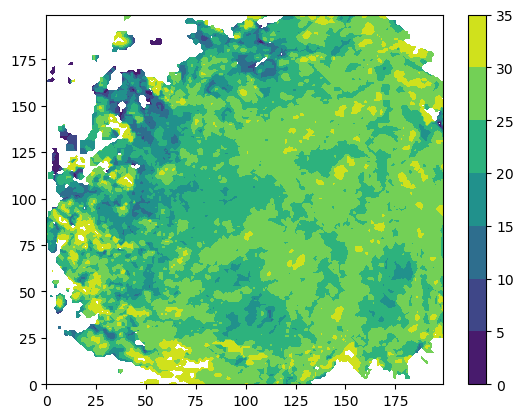

In [136]:
plt.contourf(filtered_tc_radar['swath_reflectivity'].sel(level=2,num_cases=tilt_mag.sel(num_cases=result).where(tilt_mag.sel(num_cases=result) > 50).
                                                         dropna('num_cases')['num_cases']).mean('num_cases'),levels=np.arange(0,40,5))
plt.colorbar()


In [131]:
tilt_mag.sel(num_cases=result).where(tilt_mag.sel(num_cases=result) > 50).dropna('num_cases')['num_cases']

<xarray.DataArray 'num_cases' (num_cases: 35)> Size: 280B
array([ 223,  252,  403,  407,  408,  409,  603,  604,  606,  607,  608,  742,
        744,  745,  747,  764,  797,  881,  882,  910,  911,  918,  919,  920,
        922,  924,  926,  939,  940,  941,  944,  960, 1060, 1069, 1104])
Coordinates:
  * num_cases  (num_cases) int64 280B 223 252 403 407 408 ... 960 1060 1069 1104

In [63]:
# tilt_ang = (tc_radar_data.sel(num_cases=case_loop,level=[5,5.5,6,6.5])[
#     'tc_tilt_direction'].dropna(dim='level').values* (180/np.pi))[np.nanargmax(tilt_mag.values)] # This is a math angle!!!


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 136,
 156,
 157,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 222,
 223,
 224,
 231,
 232,


In [60]:
year_cases.values,stype_cases.values

(array([   0,    1,    2, ..., 1190, 1191, 1192]),
 array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
          11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
          22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
          33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
          44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
          55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
          66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
          77,   78,   79,   80,   81,   82,   83,   85,   86,   87,   88,
          89,   90,   91,   92,   93,   99,  100,  101,  102,  103,  104,
         105,  106,  107,  108,  109,  110,  111,  112,  113,  114,  115,
         117,  118,  119,  120,  121,  122,  123,  124,  125,  126,  127,
         128,  129,  130,  131,  132,  133,  136,  139,  140,  141,  142,
         143,  144,  145,  146,  147,  156,  157,  167,  168,

In [61]:
year_cases,stype_cases

(<xarray.DataArray 'num_cases' (num_cases: 1184)> Size: 9kB
 array([   0,    1,    2, ..., 1190, 1191, 1192])
 Coordinates:
   * num_cases  (num_cases) int64 9kB 0 1 2 3 4 5 ... 1188 1189 1190 1191 1192,
 <xarray.DataArray 'num_cases' (num_cases: 771)> Size: 6kB
 array([   0,    1,    2, ..., 1187, 1188, 1189])
 Coordinates:
   * num_cases  (num_cases) int64 6kB 0 1 2 3 4 5 ... 1175 1176 1187 1188 1189)